# How to have agent respond in structured format

The typical ReAct agent prompts the LLM to respond in 1 of two formats: a
function call (~ JSON) to use a tool, or conversational text to respond to the
user.

If your agent is connected to a structured (or even generative) UI, or if it is
communicating with another agent or software process, you may want it to resopnd
in a specific structured format.

In this example we will build a conversational ReAct agent that responds in a
specific format. We will do this by using
[tool calling](https://js.langchain.com/docs/modules/model_io/models/chat/function-calling/).
This is useful when you want to enforce that an agent's response is in a
specific format. In this example, we will ask it respond as if it were a
weatherman, returning the temperature and additional info in separate,
machine-readable fields.


## Setup

First we need to install the packages required

```bash
yarn add langchain @langchain/anthropic @langchain/langgraph @langchain/core
```


Next, we need to set API keys for OpenAI (the LLM we will use).


In [1]:
// process.env.OPENAI_API_KEY = "sk_...";

Optionally, we can set API key for
[LangSmith tracing](https://smith.langchain.com/), which will give us
best-in-class observability.


In [2]:
// process.env.LANGCHAIN_API_KEY = "ls...";
process.env.LANGCHAIN_CALLBACKS_BACKGROUND = "true";
process.env.LANGCHAIN_TRACING_V2 = "true";
process.env.LANGCHAIN_PROJECT = "Respond in Format: LangGraphJS";

Respond in Format: LangGraphJS


## Set up the State


In [3]:
import { Annotation, messagesStateReducer } from "@langchain/langgraph";
import { BaseMessage } from "@langchain/core/messages";

const GraphState = Annotation.Root({
  messages: Annotation<BaseMessage[]>({
    reducer: messagesStateReducer,
  }),
});

## Set up the tools


In [4]:
import { tool } from "@langchain/core/tools";
import { z } from "zod";

const searchTool = tool((_) => {
  // This is a placeholder, but don't tell the LLM that...
  return "67 degrees. Cloudy with a chance of rain.";
}, {
  name: "search",
  description: "Call to surf the web.",
  schema: z.object({
    query: z.string().describe("The query to use in your search."),
  }),
});

const tools = [searchTool];

We can now wrap these tools in a
[ToolNode](/langgraphjs/reference/classes/langgraph_prebuilt.ToolNode.html).


In [5]:
import { ToolNode } from "@langchain/langgraph/prebuilt";

const toolNode = new ToolNode<typeof GraphState.State>(tools);

## Set up the model


In [6]:
import { ChatOpenAI } from "@langchain/openai";

const model = new ChatOpenAI({
  temperature: 0,
  model: "gpt-4o",
});

After we've done this, we should make sure the model knows that it has these
tools available to call. We can do this by binding the LangChain tools to the model class.

We also want to define a response schema for the language model and bind it to
the model as a tool. The idea is that when the model is ready to respond, it'll call this final
tool and populate arguments for it according to the schema we want. Rather than calling
a tool, we'll instead return from the graph.

Because we only intend to use this final tool to guide the schema of the model's final response,
we'll declare it with a mocked out function:

In [7]:
import { tool } from "@langchain/core/tools";

const Response = z.object({
  temperature: z.number().describe("the temperature"),
  other_notes: z.string().describe("any other notes about the weather"),
});

const finalResponseTool = tool(async () => "mocked value", {
  name: "Response",
  description: "Always respond to the user using this tool.",
  schema: Response
})

const boundModel = model.bindTools([
  ...tools,
  finalResponseTool
]);

## Define the nodes


In [8]:
import { AIMessage } from "@langchain/core/messages";
import { RunnableConfig } from "@langchain/core/runnables";

// Define the function that determines whether to continue or not
const route = (state: typeof GraphState.State) => {
  const { messages } = state;
  const lastMessage = messages[messages.length - 1] as AIMessage;
  // If there is no function call, then we finish
  if (!lastMessage.tool_calls || lastMessage.tool_calls.length === 0) {
    return "__end__";
  }
  // Otherwise if there is, we need to check what type of function call it is
  if (lastMessage.tool_calls[0].name === "Response") {
    return "__end__";
  }
  // Otherwise we continue
  return "tools";
};

// Define the function that calls the model
const callModel = async (
  state: typeof GraphState.State,
  config?: RunnableConfig,
) => {
  const { messages } = state;
  const response = await boundModel.invoke(messages, config);
  // We return an object, because this will get added to the existing list
  return { messages: [response] };
};

## Define the graph

In [9]:
import { StateGraph } from "@langchain/langgraph";

// Define a new graph
const workflow = new StateGraph(GraphState)
  .addNode("agent", callModel)
  .addNode("tools", toolNode)
  .addEdge("__start__", "agent")
  .addConditionalEdges(
    // First, we define the start node. We use `agent`.
    // This means these are the edges taken after the `agent` node is called.
    "agent",
    // Next, we pass in the function that will determine which node is called next.
    route,
    // We supply a map of possible response values to the conditional edge
    // to make it possible to draw a visualization of the graph.
    {
      __end__: "__end__",
      tools: "tools",
    }
  )
  // We now add a normal edge from `tools` to `agent`.
  // This means that after `tools` is called, `agent` node is called next.
  .addEdge("tools", "agent");

// Finally, we compile it!
// This compiles it into a LangChain Runnable,
// meaning you can use it as you would any other runnable
const app = workflow.compile();

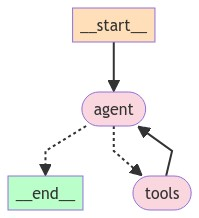

In [10]:
import * as tslab from "tslab";

const graph = app.getGraph();
const image = await graph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

## Use it!

We can now use it! This now exposes the
[same interface](https://v02.api.js.langchain.com/classes/langchain_core_runnables.Runnable.html)
as all other LangChain runnables.


In [11]:
import { HumanMessage, isAIMessage } from "@langchain/core/messages";

const prettyPrint = (message: BaseMessage) => {
  let txt = `[${message._getType()}]: ${message.content}`;
  if (
    isAIMessage(message) && message?.tool_calls?.length
  ) {
    const tool_calls = message?.tool_calls
      ?.map((tc) => `- ${tc.name}(${JSON.stringify(tc.args)})`)
      .join("\n");
    txt += ` \nTools: \n${tool_calls}`;
  }
  console.log(txt);
};

const inputs = {
  messages: [new HumanMessage("what is the weather in sf")],
};

const stream = await app.stream(inputs, { streamMode: "values" });

for await (const output of stream) {
  const { messages } = output;
  prettyPrint(messages[messages.length - 1]);
  console.log("\n---\n");
}

[human]: what is the weather in sf

---

[ai]:  
Tools: 
- search({"query":"current weather in San Francisco"})

---

[tool]: 67 degrees. Cloudy with a chance of rain.

---

[ai]:  
Tools: 
- Response({"temperature":67,"other_notes":"Cloudy with a chance of rain."})

---



## Partially streaming JSON

If we want to stream the structured output as soon as it's available, we can use the [`.streamEvents()`](https://js.langchain.com/docs/how_to/streaming#using-stream-events) method. We'll aggregate emitted `on_chat_model_events` and inspect the name field. As soon as we detect that the model is calling the final output tool, we can start logging the relevant chunks.

Here's an example:

In [12]:
import { concat } from "@langchain/core/utils/stream";

const eventStream = await app.streamEvents(inputs, { version: "v2" });

let aggregatedChunk;
for await (const { event, data } of eventStream) {
  if (event === "on_chat_model_stream") {
    const { chunk } = data;
    if (aggregatedChunk === undefined) {
      aggregatedChunk = chunk;
    } else {
      aggregatedChunk = concat(aggregatedChunk, chunk);
    }
    const currentToolCalls = aggregatedChunk.tool_calls;
    if (
      currentToolCalls.length === 0 ||
      currentToolCalls[0].name === "" ||
      !finalResponseTool.name.startsWith(currentToolCalls[0].name)
    ) {
      // No tool calls or a different tool call in the message,
      // so drop what's currently aggregated and start over
      aggregatedChunk = undefined;
    } else if (currentToolCalls[0].name === finalResponseTool.name) {
      // Now we're sure that this event is part of the final output!
      // Log the partially aggregated args.
      console.log(aggregatedChunk.tool_call_chunks[0].args);

      // You can also log the raw args instead:
      // console.log(chunk.tool_call_chunks);

      console.log("---");
    }
  }
}
// Final aggregated tool call
console.log(aggregatedChunk.tool_calls);


---
{"
---
{"temperature
---
{"temperature":
---
{"temperature":67
---
{"temperature":67,"
---
{"temperature":67,"other
---
{"temperature":67,"other_notes
---
{"temperature":67,"other_notes":"
---
{"temperature":67,"other_notes":"Cloud
---
{"temperature":67,"other_notes":"Cloudy
---
{"temperature":67,"other_notes":"Cloudy with
---
{"temperature":67,"other_notes":"Cloudy with a
---
{"temperature":67,"other_notes":"Cloudy with a chance
---
{"temperature":67,"other_notes":"Cloudy with a chance of
---
{"temperature":67,"other_notes":"Cloudy with a chance of rain
---
{"temperature":67,"other_notes":"Cloudy with a chance of rain."
---
{"temperature":67,"other_notes":"Cloudy with a chance of rain."}
---
{"temperature":67,"other_notes":"Cloudy with a chance of rain."}
---
[
  {
    name: 'Response',
    args: { temperature: 67, other_notes: 'Cloudy with a chance of rain.' },
    id: 'call_oOhNx2SdeelXn6tbenokDtkO',
    type: 'tool_call'
  }
]
